本节任务：构建一个可以识别简单手语的人工智能程序

In [1]:
# 导入必须的库
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)


## 手语数据库

 - 训练数据集：1080张图（64 * 64 像素），表示 0-5 的数字，每个数字有 180 张不同的图像，这些图像稍微有些不同
 - 测试数据集：120张图 （64 * 64 像素），表示 0-5 的数字，每个数字有 20 张不同的图像

![](./images/hands.png)

In [6]:
# 加载数据集

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

print('X_train_orig.shape = ' + str(X_train_orig.shape))


X_train_orig.shape = (1080, 64, 64, 3)


y = 5


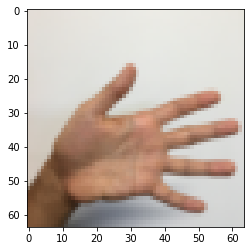

In [4]:
# 挑选一个元素来展示

index = 0
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [8]:
# 对数据进行扁平化处理 
# 1080 * 64 * 64 * 3 展开成 12288 * 1080
X_train_flattern = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flattern = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# 简单的归一化
# 将数据转换为 0 - 1 之间的数
X_train = X_train_flattern / 255.
X_test = X_test_flattern / 255.

# one_hot 编码
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


我们的模型大致结构是 LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX。

### 创建占位符

我们第一个任务就是为 X 和 Y 创建占位符，这样我们就可以在执行计算图的时候，将训练集的数据填充到 tensorflow 的计算图中了。

In [9]:
# 创建占位符

def create_placeholder(n_x, n_y):
    '''
    n_x -- 图片向量的大小，本例中是 12288
    n_y -- 类别数量，因为是 0-5 的数字，所以数量是 6
    '''

    '''
    tf.placeholder(dtype, shape=None, name=None)
    第二个参数的是数据的维度，如下传入 [n_x, None] 表示 n_x 行，不确定列
    因为我们执行训练时，样本的数量是不同的
    '''
    X = tf.placeholder(tf.float32, [n_x, None], name='X')
    Y = tf.placeholder(tf.float32, [n_y, None], name='Y')

    return X, Y

In [10]:
X, Y = create_placeholder(12288, 6)
print('X = ', str(X))
print('Y = ' + str(Y))

X =  Tensor("X:0", shape=(12288, None), dtype=float32)
Y = Tensor("Y:0", shape=(6, None), dtype=float32)


### 初始化参数

我们的第二个任务就是用 tensorflow 来初始化神经网络模型的参数 W 和 b。

In [32]:
# 初始化参数

def initialize_parameters():
    # 固定随机数种子
    tf.set_random_seed(1)

    '''
    初始化参数的 API：tf.get_variable(name, shape, initializer)
    tf.truncated_normal_initializer：截取的正态分布
    '''
    W1 = tf.get_variable('W1', [25, 12288], initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    # 我们将 b 初始化为 0
    b1 = tf.get_variable('b1', [25, 1], initializer=tf.zeros_initializer())

    W2 = tf.get_variable('W2', [12, 25], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b2 = tf.get_variable('b2', [12, 1], initializer=tf.zeros_initializer())

    W3 = tf.get_variable('W3', [6, 12], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b3 = tf.get_variable('b3', [6, 1], initializer=tf.zeros_initializer())

    return {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2,
        'W3': W3,
        'b3': b3
    }

In [34]:
tf.reset_default_graph()
parameters = initialize_parameters()
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32>


In [33]:
# 前向传播

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # 计算第一层的 z，使用 relu 激活函数
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)

    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)

    Z3 = tf.add(tf.matmul(W3, A2), b3)
    # 没有计算 A3 是因为 tensorflow 会在计算成本时一起计算 A3

    return Z3

In [35]:
tf.reset_default_graph()
X, Y = create_placeholder(12288, 6)
parameters = initialize_parameters()
Z3 = forward_propagation(X, parameters)
print('Z3 = ' + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, None), dtype=float32)


### 计算 cost 成本

```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
- logits 是最后一层的输出，即 Z3，labels 是真实标签，即 Y
- tf.reduce_mean 是获取张量中所有元素的平均值，这里指每个样本的平均值

In [20]:
# 计算 cost 

def compute_cost(Z3, Y):
    # tf.transpose 表示转置
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    return cost

In [23]:
tf.reset_default_graph()

X, Y = create_placeholder(12288, 6)
parameters = initialize_parameters()
Z3 = forward_propagation(X, parameters)
cost = compute_cost(Z3, Y)
print('cost = ' + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


### 反向传播和更新

我们可以使用 tensorflow 的一行代码完成反向传播和参数更新。

只需要创建一个 optimizer 实例对象，这个实例对象可以指定优化算法，例如可以指定是用标准的梯度下降算法还是 adam 梯度下降算法。还需要指定学习率以及和哪一个 cost 函数合作。

```python
# 创建一个使用标准梯度下降算法的 optimizer 实例对象
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

# 执行 optimizer 的操作
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

In [36]:
# 构建模型

def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs=1500, 
        minibatch_size=32, print_cost=True):
    ops.reset_default_graph()       # 将计算图返回到默认空状态
    tf.set_random_seed(1)

    seed = 3
    (n_x, m) = X_train.shape        # (n_x：特征数量，m：训练集中的样本数)
    n_y = Y_train.shape[0]
    costs = []

    # 创建占位符
    X, Y = create_placeholder(n_x, n_y)

    # 初始化参数
    parameters = initialize_parameters()

    # 构建前向传播操作
    Z3 = forward_propagation(X, parameters)

    # 构建成本计算操作
    cost = compute_cost(Z3, Y)

    # 构建反向传播，指定优化算法、学习率和成本函数，这里我们使用 adam 算法
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # 定义初始化操作
    init = tf.global_variables_initializer()

    # 开始一个 tensorflow 的 session
    with tf.Session() as session:
        
        # 执行初始化操作
        session.run(init)

        # 执行 epochs 指定的训练次数，一个 epoch 就是完整地向整个数据集学习一次
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)   # 计算子训练集数量
            seed = seed + 1

            # 将训练集分成若干子训练集
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            # 遍历每个子训练集
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                # 执行整个训练图
                _, minibatch_cost = session.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        # 画出cost成本的走势图
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 从计算图中获取训练好了的参数
        parameters = session.run(parameters)
        print("Parameters have been trained!")

        # 计算在训练集和测试集上的预测精确度
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        print('Train Accuracy:', accuracy.eval({X: X_train, Y: Y_train}))
        print('Test Accuracy:', accuracy.eval({X: X_test, Y: Y_test}))

        return parameters

Cost after epoch 0: 1.859356
Cost after epoch 100: 0.797117
Cost after epoch 200: 0.459786
Cost after epoch 300: 0.269190
Cost after epoch 400: 0.155759
Cost after epoch 500: 0.079337
Cost after epoch 600: 0.046178
Cost after epoch 700: 0.021931
Cost after epoch 800: 0.008391
Cost after epoch 900: 0.004791
Cost after epoch 1000: 0.002244
Cost after epoch 1100: 0.001133
Cost after epoch 1200: 0.000872
Cost after epoch 1300: 0.000494
Cost after epoch 1400: 0.000417


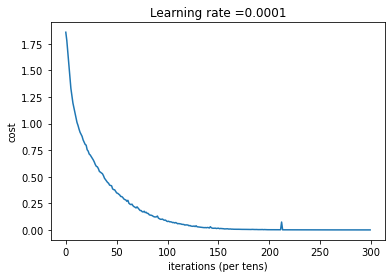

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.8833333


2022-06-09 22:10:50.498319: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 53084160 exceeds 10% of free system memory.


In [37]:
# 训练模型

parameters = model(X_train, Y_train, X_test, Y_test)